In [ ]:
!pip install opencv-python==4.8.0.76

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 9.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.10.0.84
    Uninstalling opencv-python-4.10.0.84:
      Successfully uninstalled opencv-python-4.10.0.84


In [ ]:
!pip install virtualenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 27.8 MB/s eta 0:00:00


In [ ]:
!virtualenv my_env

created virtual environment CPython3.10.12.final.0-64 in 1564ms
  creator CPython3Posix(dest=/content/my_env, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==24.2, setuptools==75.1.0, wheel==0.44.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [ ]:
!source my_env/bin/activate

/bin/bash: line 1: my_env/bin/activate: No such file or directory


In [ ]:
import cv2
import numpy as np
import os
from sklearn.svm import OneClassSVM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/bottle dataset'

good_images = []
for filename in os.listdir(os.path.join(dataset_path, 'train', 'good')):
    img = cv2.imread(os.path.join(dataset_path, 'train', 'good', filename), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))
    good_images.append(img)

In [ ]:
hog = cv2.HOGDescriptor()

batch_size = 32
good_features = []
for i in range(0, len(good_images), batch_size):
    batch = good_images[i : i + batch_size]
    batch_features = []
    for img in batch:
        features = hog.compute(img)
        batch_features.append(features)
    good_features.extend(batch_features)

good_features = np.array(good_features)

In [ ]:
svm = OneClassSVM(kernel='rbf', nu=0.01)
svm.fit(good_features)

OneClassSVM(nu=0.01)

In [ ]:
def predict_anomaly(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))
    features = hog.compute(img)
    prediction = svm.predict(features.reshape(1, -1))
    return prediction[0] == -1

In [ ]:
test_folder = os.path.join(dataset_path, 'test')
for subfolder in os.listdir(test_folder):
    subfolder_path = os.path.join(test_folder, subfolder)
    for filename in os.listdir(subfolder_path):
        img_path = os.path.join(subfolder_path, filename)
        is_anomaly = predict_anomaly(img_path)
        print(f"Image: {img_path}, Anomaly: {is_anomaly}")

Image: /content/drive/MyDrive/Colab Notebooks/bottle dataset/test/contamination/000.png, Anomaly: True
Image: /content/drive/MyDrive/Colab Notebooks/bottle dataset/test/contamination/001.png, Anomaly: True
Image: /content/drive/MyDrive/Colab Notebooks/bottle dataset/test/contamination/005.png, Anomaly: True
Image: /content/drive/MyDrive/Colab Notebooks/bottle dataset/test/contamination/003.png, Anomaly: True
Image: /content/drive/MyDrive/Colab Notebooks/bottle dataset/test/contamination/014.png, Anomaly: True
Image: /content/drive/MyDrive/Colab Notebooks/bottle dataset/test/contamination/011.png, Anomaly: True
Image: /content/drive/MyDrive/Colab Notebooks/bottle dataset/test/contamination/018.png, Anomaly: True
Image: /content/drive/MyDrive/Colab Notebooks/bottle dataset/test/contamination/004.png, Anomaly: True
Image: /content/drive/MyDrive/Colab Notebooks/bottle dataset/test/contamination/020.png, Anomaly: True
Image: /content/drive/MyDrive/Colab Notebooks/bottle dataset/test/contami

Prediction for /content/drive/MyDrive/Colab Notebooks/bottle dataset/test/broken_large/005.png: [-1]
Mask loaded for /content/drive/MyDrive/Colab Notebooks/bottle dataset/test/broken_large/005.png


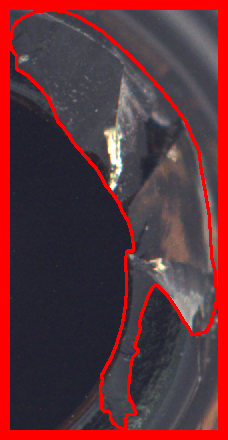

In [ ]:
from google.colab.patches import cv2_imshow

def annotate_anomaly(img_path, mask_path=None):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image: {img_path}")
        return None

    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img_gray is None:
        print(f"Failed to load grayscale image: {img_path}")
        return None

    img_original = img.copy()

    img_resized = cv2.resize(img_gray, (128, 128))

    features = hog.compute(img_resized)
    if features is None:
        print(f"Failed to compute HOG features for: {img_path}")
        return None

    prediction = svm.predict(features.reshape(1, -1))
    print(f"Prediction for {img_path}: {prediction}")

    if prediction[0] == -1:  # Anomaly detected
        if mask_path is not None:
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if mask is None:
                print(f"Mask not found for {mask_path}")
                return None

            print(f"Mask loaded for {img_path}")

            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if len(contours) > 0:
                x, y, w, h = cv2.boundingRect(contours[0])
                cropped_img = img_original[y:y+h, x:x+w]

                cropped_img_contours = cropped_img.copy()
                offset_contours = [np.array([[[pt[0][0] - x, pt[0][1] - y]] for pt in cnt]) for cnt in contours]
                cv2.drawContours(cropped_img_contours, offset_contours, -1, (0, 0, 255), 2)

                cropped_img_with_border = cv2.copyMakeBorder(cropped_img_contours, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[0, 0, 255])

                cv2_imshow(cropped_img_with_border)

                return cropped_img_with_border
            else:
                print(f"No contours found for {mask_path}")
        else:
            print(f"Mask path is None for {img_path}")

    else:  # No anomaly detected
        print(f"No anomaly detected for {img_path}")
        img_with_border = cv2.copyMakeBorder(img, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[0, 255, 0])
        cv2_imshow(img_with_border)
        return img_with_border


img_path = '/content/drive/MyDrive/Colab Notebooks/bottle dataset/test/broken_large/005.png'
mask_path = img_path.replace('test', 'ground_truth').replace('.png', '_mask.png')
output = annotate_anomaly(img_path, mask_path)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def predict_anomaly(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))
    features = hog.compute(img)
    prediction = svm.predict(features.reshape(1, -1))
    return prediction[0] == -1

test_folder = os.path.join(dataset_path, 'test')

true_labels = []
predicted_labels = []

for subfolder in os.listdir(test_folder):
    subfolder_path = os.path.join(test_folder, subfolder)
    for filename in os.listdir(subfolder_path):
        img_path = os.path.join(subfolder_path, filename)

        true_label = 0 if subfolder == 'good' else 1

        is_anomaly = predict_anomaly(img_path)
        predicted_label = 1 if is_anomaly else 0

        true_labels.append(true_label)
        predicted_labels.append(predicted_label)

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.8554
Precision: 0.9180
Recall: 0.8889
